In [2]:
%cd ..

/home/tianshu/prediction


In [3]:
import json

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from jax import numpy as jnp
from jax import vmap

from forecast import Dataset, Method

In [5]:
ds = Dataset("data.npz", if_data="if.npz", offset=1000. * 1000.)

with open("results/manifest.json") as f:
    methods = json.load(f)
    
results = {
    method: Method("results/{}".format(method), ds, desc)
    for method, desc in tqdm(methods.items())
}

  0%|          | 0/27 [00:00<?, ?it/s]

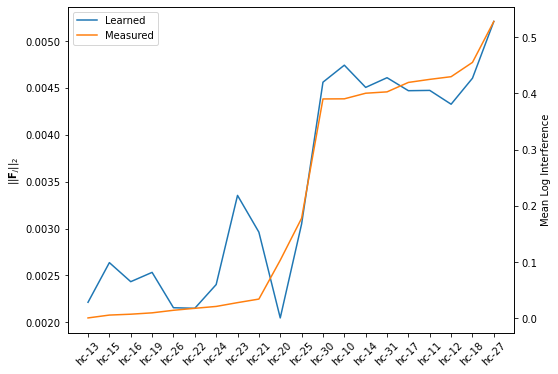

In [85]:
# Interference Magnitude
# L2 matrix norm is max_{m_i, m_k} m_i^TF_jm_k, i.e. the maximum possible
# interference achieved by a pair of modules in our embedding space.

def _interference_magnitude():

    def spectral_norm(v_s, v_g):
        return jnp.linalg.norm(jnp.matmul(v_s, v_g.T))

    vvv = vmap(vmap(vmap(spectral_norm)))
    res = np.load("results/interference/0.9.npz")
    norms = jnp.mean(vvv(res["V_s"], res["V_g"]), axis=(0, 1))

    df = pd.read_csv("data/if2.csv")
    mean_interference = np.array(df.groupby("runtime")["diff"].mean())

    order = np.argsort(mean_interference)

    fig, ax1 = plt.subplots(1, 1, figsize=(8, 6))
    ln1 = ax1.plot(norms[order], label="Learned")
    ax1.set_xticks(np.arange(len(ds.runtimes)))
    ax1.set_xticklabels(ds.runtimes[order], rotation=45)
    ax1.set_ylabel("$||\mathbf{F}_j||_2$")

    ax2 = ax1.twinx()
    ln2 = ax2.plot(mean_interference[order], color='C1', label="Measured")
    ax2.set_ylabel("Mean Log Interference")

    ax1.legend(ln1 + ln2, [l.get_label() for l in ln1 + ln2])
    fig.savefig("figures/interference_interp.png", dpi=300)

_interference_magnitude()

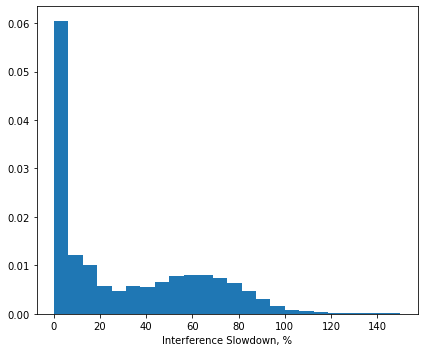

In [15]:
# Interference Histogram

def _interference_histogram():
    df = pd.read_csv("data/if.csv")
    fig, axs = plt.subplots(1, 1, figsize=(6, 5))
    axs.hist(
        100 * (np.exp(df["diff"]) - 1),
        bins=np.linspace(0, 150, 25), density=True)
    axs.set_xlabel("Interference Slowdown, %")
    fig.tight_layout()
    fig.savefig("figures/interference_hist.png", dpi=300)

_interference_histogram()

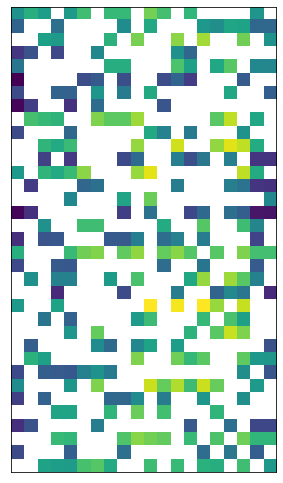

In [25]:
# Matrix Completion

def _matrix_completion():
    ds = Dataset("data/data.npz", if_data="data/if.npz", offset=1000. * 1000.)

    mat = ds.matrix[30:65]
    random_mask = np.random.rand(*mat.shape) > 0.4
    mat = np.ma.masked_where(random_mask == 1, mat)
    cmap = matplotlib.cm.viridis.copy()
    cmap.set_bad(color='white')

    fig, axs = plt.subplots(1, 1, figsize=(mat.shape[1] / 5, mat.shape[0] / 5))
    axs.imshow(mat, cmap=cmap)
    axs.set_xticks([])
    axs.set_yticks([])
    fig.tight_layout()
    fig.savefig("figures/matrix_completion.png", dpi=300, bbox_inches='tight')

_matrix_completion()

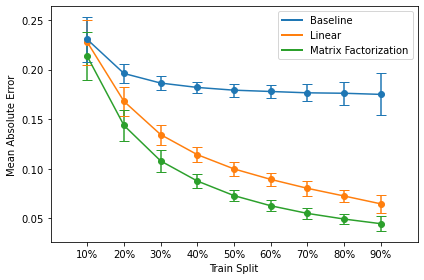

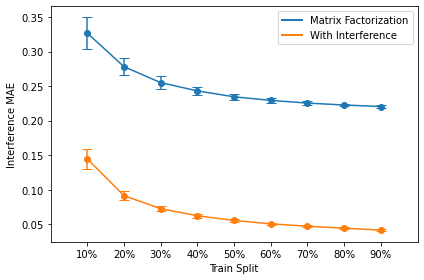

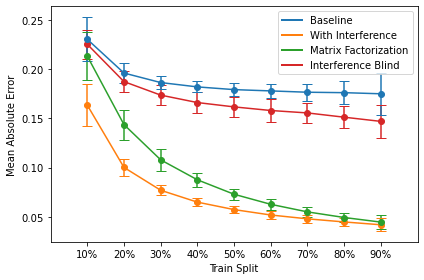

In [45]:
# Comparisons

from matplotlib.pyplot import Line2D


def plots(subset, ax=None, boxplot=True, baseline=True, key="error", labels={}):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
    colors = [
        "C{}".format(i + (1 if baseline else 0)) for i in range(len(subset))]
    legend = [labels.get(m, methods.get(m)) for m in subset]
    for color, method in zip(colors, subset):
        results[method].compare(ax, color=color, boxplot=boxplot, key=key)

    if baseline:
        colors = ["C0"] + colors
        legend = ["Baseline"] + legend
        results["Lr8"].compare(ax, color='C0', boxplot=boxplot, key="baseline")
        
    ax.legend(
        [Line2D([0], [0], color=c, lw=2) for c in colors], legend,
        loc='upper right')


def _method_comparisons():

    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    plots(
        ["Lr64", "embedding"], ax=axs, boxplot=False, baseline=True,
        key="error", labels={"Lr64": "Linear"})
    fig.tight_layout()
    fig.savefig("figures/non-interference.png", dpi=300)

    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    plots(
        ["embedding", "interference"], ax=axs, boxplot=False,
        baseline=False, key="interference")
    axs.set_ylabel("Interference MAE")
    fig.tight_layout()
    fig.savefig("figures/interference.png", dpi=300)

    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    plots(
        ["interference", "embedding", "ignore"], ax=axs, boxplot=False,
        baseline=True, key="error")
    fig.tight_layout()
    fig.savefig("figures/interference_error.png", dpi=300)


_method_comparisons()

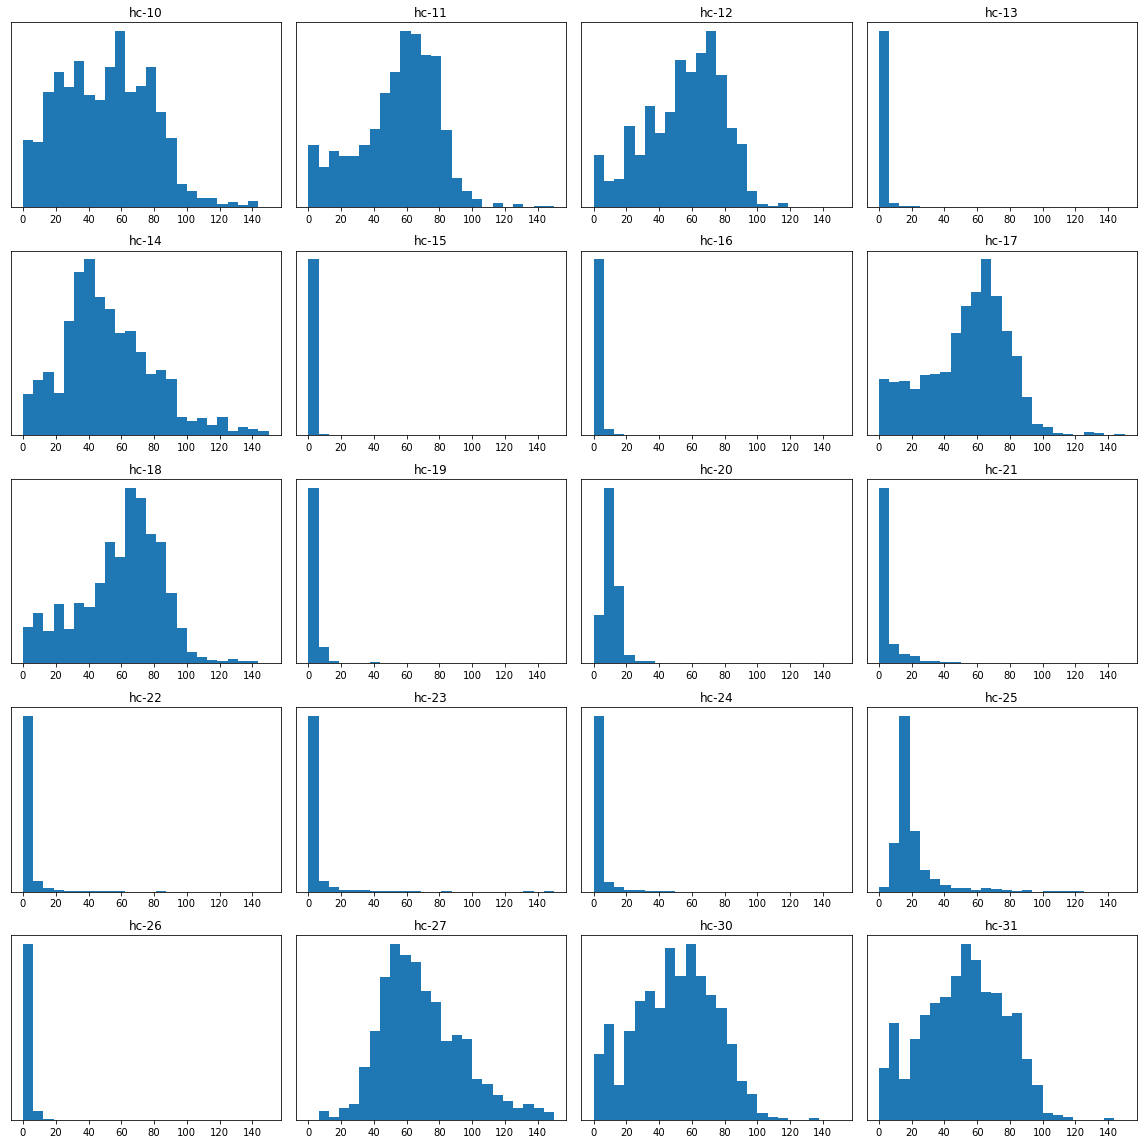

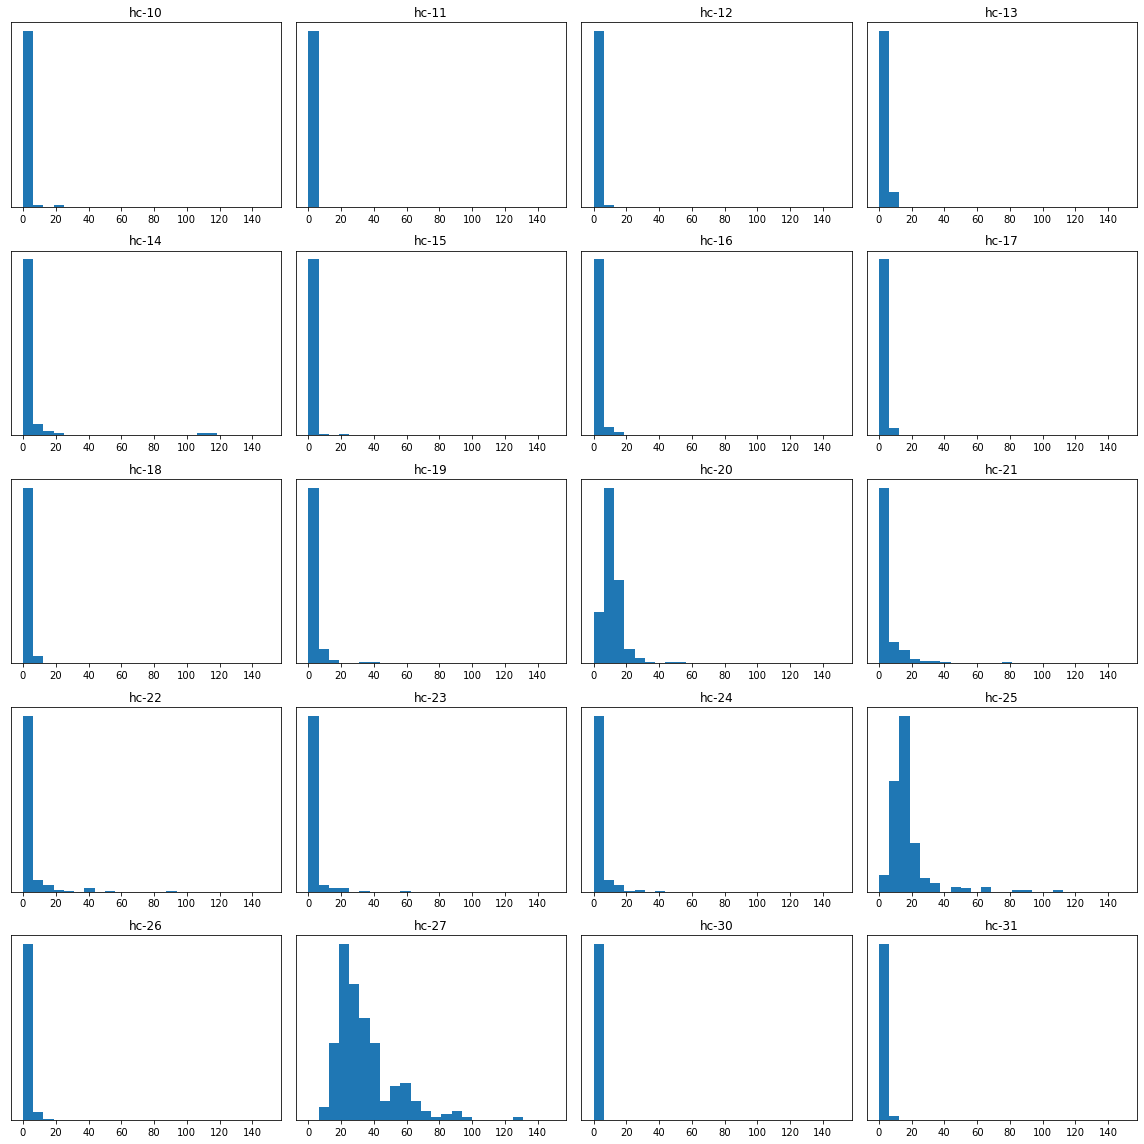

In [26]:
def _interference_runtime(data, out):
    fig, axs = plt.subplots(5, 4, figsize=(16, 16))
    df = pd.read_csv(data)

    for rt, ax in zip(ds.runtimes, axs.reshape(-1)):
        ax.hist(
            100 * (np.exp(df[df["runtime"] == rt]["diff"]) - 1),
            np.linspace(0, 150, 25), density=True)
        ax.set_yticks([])
        ax.set_title(rt)

    fig.tight_layout()
    fig.savefig(out, dpi=300, bbox_inches='tight')

_interference_runtime(
    "data/if.csv", "figures/interference_runtime.png")
_interference_runtime(
    "data/if.multicore.csv", "figures/interference_multicore.png")